In [9]:
#libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import requests as req

In [10]:
#Covid Data 
cov_key = "2c3b686a09214915b1471a2f0df00d20"
cov_url = "https://api.covidactnow.org/v2/states.json?apiKey="+cov_key

#Get data
cov_data = req.get(cov_url).json()

#Create dataframe
df = pd.DataFrame(cov_data)

In [11]:
#Voting Data 
vote_data = pd.read_csv(r'../data/pop_vote.csv')

#Make a dictionary with the states as keys and the democratic margin as values
vote_dict = dict(zip(vote_data['state'], vote_data['dem_this_margin']))

#Dict of abbreviations and full names
state_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

def get_color(dem_margin):
    margin_num = float(dem_margin[:-1])
    if margin_num > 0:
        return 'blue'
    else:
        return 'red'

def get_alpha(dem_margin):
    margin_num = float(dem_margin[:-1])
    if margin_num > 0:
        return margin_num/45
    else:
        return -margin_num/45

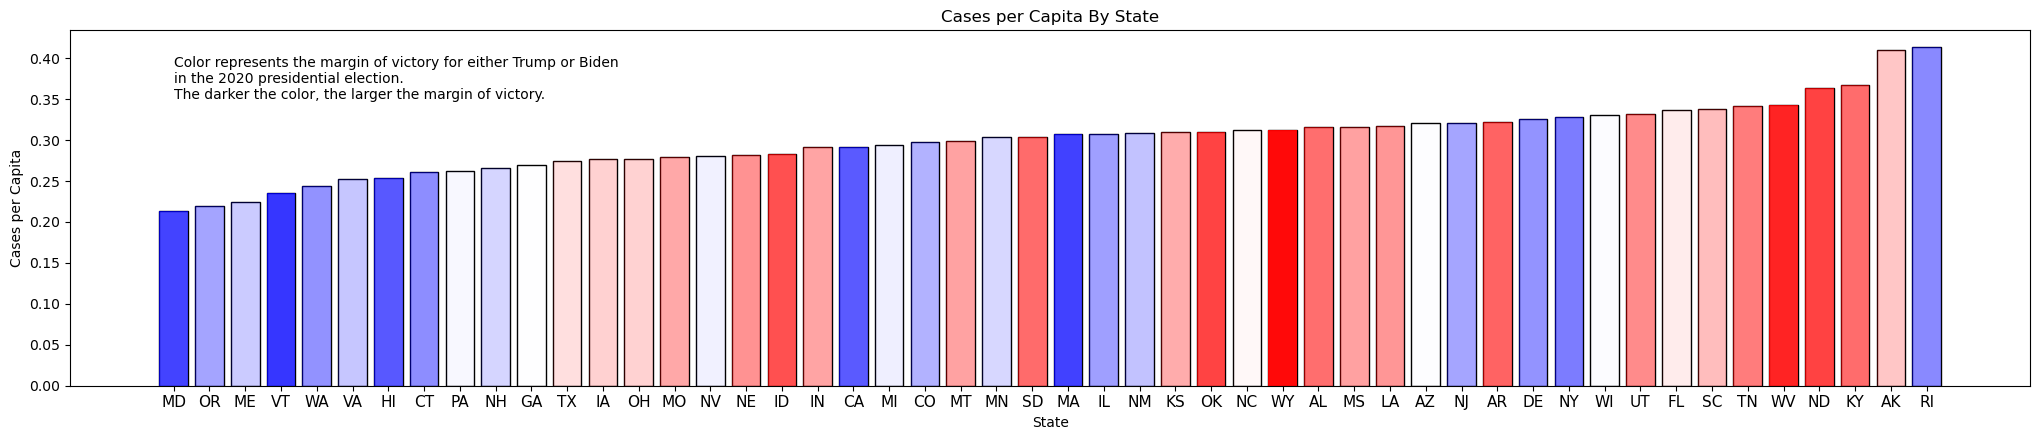

In [12]:
#Create a bar chart with the number of deaths per state

cases = []

#Get an array of deaths by state
for i in range(len(df)):
    cases.append(df['actuals'][i]['cases'])

#Create an array of population by state
pop = []
for i in range(len(df)):
    pop.append(df['population'][i])

#Deaths per captia
deaths_per_captia = []
for i in range(len(df)):
    deaths_per_captia.append(cases[i]/pop[i])

#Create a dictionary of states and deaths per captia
states = df['state'].to_list()
d = dict(zip(states, deaths_per_captia))

#Sort the dictionary
d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}

#Create a bar chart
plt.figure(0)

for key, value in d.items():
    try:
        state_name = state_dict[key]
        plt.bar(key, value, color='white', edgecolor='black')
        plt.bar(key, value, color=get_color(vote_dict[state_name]), alpha=get_alpha(vote_dict[state_name]))
    except KeyError:
        pass

plt.rcParams["figure.figsize"] = [20.50, 4.50]
plt.tick_params(axis='x', which='major', labelsize=11)
plt.rcParams["figure.autolayout"] = True
plt.title('Cases per Capita By State')
plt.xlabel('State')
plt.ylabel('Cases per Capita')
plt.text(0, .35, 'Color represents the margin of victory for either Trump or Biden \nin the 2020 presidential election. \nThe darker the color, the larger the margin of victory.')
plt.show()